# Setup

In [21]:
from array import array
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory
from metrics import ConfusionMatrixGenerator
from joblib import dump
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'program_comprehension_challenge'
report_dict_list = []

In [22]:
X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)

# Show the datasets value counts
dataset_dict = {}
dataset_dict['Training Dataset'] = len(training_dataset.loc[training_dataset[LABEL] == "Yes"]), len(training_dataset.loc[training_dataset[LABEL] == "No"]), len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset)
dataset_dict['Test Dataset'] = len(test_dataset.loc[test_dataset[LABEL] == "Yes"]), len(test_dataset.loc[test_dataset[LABEL] == "No"]), len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset)
df = DataFrame.from_dict(dataset_dict, orient='index', columns=['Label (Yes)', 'Label (No)', 'Ratio (Yes)'])

df

,Label (Yes),Label (No),Ratio (Yes)
Training Dataset,92,506,0.153846
Test Dataset,39,111,0.260000


# Set up

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from nlp import LemmaTokenizer
from metrics import ConfusionMatrixGenerator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

is_author_categories = [
    False,  # 0 should come before 1 for numerical columns.
    True
]

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow', CountVectorizer(stop_words='english'), 'body'),
        ('body_tfidf_stemming', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        (
            'body_tfidf_lemma',
            TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True, ngram_range=(1, 2)),
            'body'
        ),
        ('dac', OneHotEncoder(categories=[dac_labels]), ['dialogue_act_classification_ml']),
        ('is_author', OneHotEncoder(categories=[is_author_categories]), ['comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow': 0,
        'body_tfidf_stemming': 0,
        'body_tfidf_lemma': 4,
        'dac': 1,
        'is_author': 2,
    },
    verbose=False)

yes_fbeta_precision_scorer = metrics.make_scorer(metrics.fbeta_score, beta=0.5, pos_label='Yes')

# Tuning the model with Grid Search - MultinomialNB

In [24]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            MultinomialNB(alpha=0, fit_prior=True)
        )
    ],
    verbose=False)

grid_search_cv_params = [
    {
        # 'classifier__alpha': [0, 1.5, 1, 2, 10],
        # 'classifier__fit_prior': [True, False],
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished


{}

In [25]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.988471,1.144577,0.703191,1.120784,{},0.638298,0.581395,0.454545,0.3,0.5,0.494848,0.116349,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [26]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'GridSearch MultinomialNB': report})

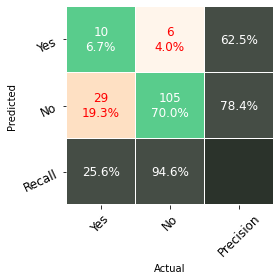

In [27]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=['Yes', 'No'])
ConfusionMatrixGenerator.print_confusion_matrix(cm, ["Yes", "No"], figsize=[4, 4], number_formatting='.1f', font_size=12)

# Tuning the model with Grid Search - LogisticRegression

In [28]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            LogisticRegression(C=500000, solver='sag', multi_class='auto', dual=False, random_state=19)
        )
    ],
    verbose=False)

grid_search_cv_params = [
    {
        # 'classifier__C': [0, 1, 10, 500000],
        # 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        # 'classifier__multi_class': ['auto', 'ovr', 'multinomial'],
        # # 'classifier__intercept_scaling': [0, 0.5, 1, 10],
        # 'classifier__dual': [True, False],
        # 'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        # 'classifier__C': [500000],
        # 'classifier__solver': ['sag'],
        # 'classifier__multi_class': ['auto'],
        # 'classifier__intercept_scaling': [0, 0.5, 1, 10],
        # 'classifier__dual': [False],
        # 'classifier__random_state': list(range(0, 50)),
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.6s remaining:    9.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


{}

In [29]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.033629,1.173899,0.695378,1.097556,{},0.762712,0.689655,0.612245,0.714286,0.757576,0.707295,0.054761,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [30]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'GridSearch LogisticRegression': report})

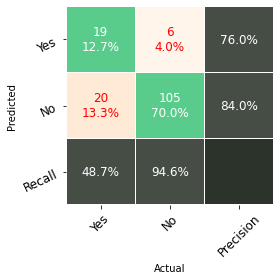

In [31]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=['Yes', 'No'])
ConfusionMatrixGenerator.print_confusion_matrix(cm, ["Yes", "No"], figsize=[4, 4], number_formatting='.1f', font_size=12)

# Tuning the model with Grid Search - SGDClassifier

In [32]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            SGDClassifier(random_state=18)
        )
    ],
    verbose=False)

grid_search_cv_params = [
    {
        # 'classifier__random_state': list(range(1, 20)),
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.8s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished


{}

In [33]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.132544,1.210728,0.734881,1.190115,{},0.793651,0.633803,0.614035,0.769231,0.862069,0.734558,0.095531,1,1.0,1.0,1.0,1.0,0.99162,0.998324,0.003352


In [34]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'GridSearch SGDClassifier': report})

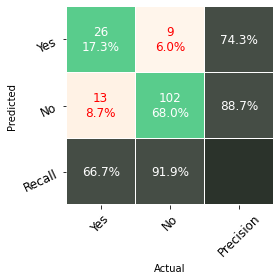

In [35]:
cm = metrics.confusion_matrix(y_true, y_pred, labels=['Yes', 'No'])
ConfusionMatrixGenerator.print_confusion_matrix(cm, ["Yes", "No"], figsize=[4, 4], number_formatting='.1f', font_size=12)

# MultinomialNB

In [36]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            MultinomialNB(alpha=0, fit_prior=True)
        )
    ],
    verbose=False)
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 4, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 0, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'MultinomialNB - BoW': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 4, 'body_tfidf_lemma': 0, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'MultinomialNB - Stemming + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__body_tfidf_lemma__tokenizer': [None],
    'preprocessor__body_tfidf_lemma__stop_words': [None],
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'MultinomialNB - Keep Stop Words + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__body_tfidf_lemma__tokenizer': [LemmaTokenizer()],
    'preprocessor__body_tfidf_lemma__stop_words': ['english'],
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'MultinomialNB - Remove Stop Words + Lemmatization + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 0, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'MultinomialNB - Body Text + Comment is by Author': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 0}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'MultinomialNB - Body Text + DAC': report})
##################################################################################################

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.1s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Par

# LogisticRegression

In [37]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            LogisticRegression(C=500000, solver='sag', multi_class='auto', dual=False)
        )
    ],
    verbose=False)
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 4, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 0, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'LogisticRegression - BoW': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 4, 'body_tfidf_lemma': 0, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'LogisticRegression - Stemming + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__body_tfidf_lemma__tokenizer': [None],
    'preprocessor__body_tfidf_lemma__stop_words': [None],
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'LogisticRegression - Keep Stop Words + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__body_tfidf_lemma__tokenizer': [LemmaTokenizer()],
    'preprocessor__body_tfidf_lemma__stop_words': ['english'],
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'LogisticRegression - Remove Stop Words + Lemmatization + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 0, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'LogisticRegression - Body Text + Comment is by Author': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 0}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'LogisticRegression - Body Text + DAC': report})
##################################################################################################

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Par

# SGDClassifier

In [38]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            SGDClassifier(random_state=18)
        )
    ],
    verbose=False)
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 4, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 0, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'SGDClassifier - BoW': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 4, 'body_tfidf_lemma': 0, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'SGDClassifier - Stemming + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__body_tfidf_lemma__tokenizer': [None],
    'preprocessor__body_tfidf_lemma__stop_words': [None],
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'SGDClassifier - Keep Stop Words + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__body_tfidf_lemma__tokenizer': [LemmaTokenizer()],
    'preprocessor__body_tfidf_lemma__stop_words': ['english'],
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'SGDClassifier - Remove Stop Words + Lemmatization + TFIDF': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 0, 'is_author': 2}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'SGDClassifier - Body Text + Comment is by Author': report})
##################################################################################################
grid_search_cv_params = [{
    'preprocessor__transformer_weights': [
            {'body_bow': 0, 'body_tfidf_stemming': 0, 'body_tfidf_lemma': 4, 'dac': 1, 'is_author': 0}
    ]
}]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_fbeta_precision_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, output_dict=True)
report['Yes']['F-beta Score'] = metrics.fbeta_score(y_true, y_pred, beta=0.5, pos_label='Yes')
report_dict_list.append({'SGDClassifier - Body Text + DAC': report})
##################################################################################################

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Par

# Performance Result Comparison

In [39]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'yes_fb_score': [next(iter(report.values()))['Yes']['F-beta Score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],    
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],    
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Algorithms,yes_fb_score,yes_precision,yes_recall,no_precision,no_recall,no_f1_score,yes_f1_score,Accuracy
0,GridSearch MultinomialNB,0.485437,0.625000,0.256410,0.783582,0.945946,0.857143,0.363636,0.766667
1,GridSearch LogisticRegression,0.683453,0.760000,0.487179,0.840000,0.945946,0.889831,0.593750,0.826667
2,GridSearch SGDClassifier,0.726257,0.742857,0.666667,0.886957,0.918919,0.902655,0.702703,0.853333
3,MultinomialNB - BoW,0.323741,0.360000,0.230769,0.760000,0.855856,0.805085,0.281250,0.693333
4,MultinomialNB - Stemming + TFIDF,0.420561,0.529412,0.230769,0.774436,0.927928,0.844262,0.321429,0.746667
5,MultinomialNB - Keep Stop Words + TFIDF,0.329670,0.461538,0.153846,0.759124,0.936937,0.838710,0.230769,0.733333
6,MultinomialNB - Remove Stop Words + Lemmatizat...,0.485437,0.625000,0.256410,0.783582,0.945946,0.857143,0.363636,0.766667
7,MultinomialNB - Body Text + Comment is by Author,0.467290,0.588235,0.256410,0.781955,0.936937,0.852459,0.357143,0.760000
8,MultinomialNB - Body Text + DAC,0.505051,0.666667,0.256410,0.785185,0.954955,0.861789,0.370370,0.773333
9,LogisticRegression - BoW,0.000000,0.000000,0.000000,0.740000,1.000000,0.850575,0.000000,0.740000


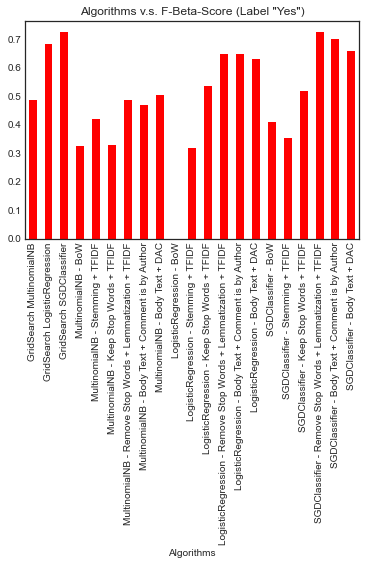

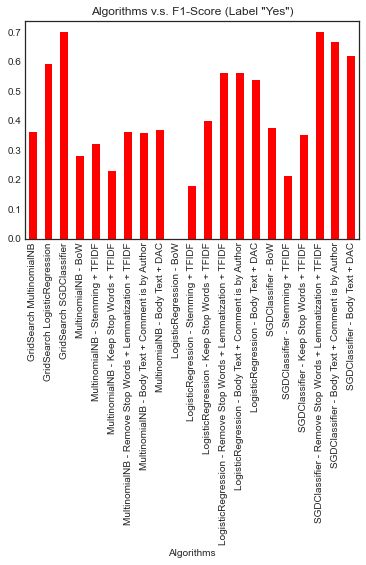

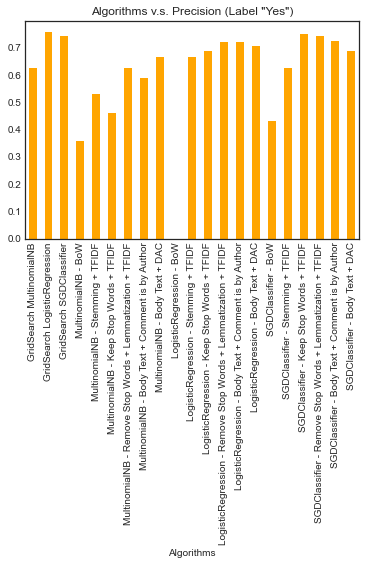

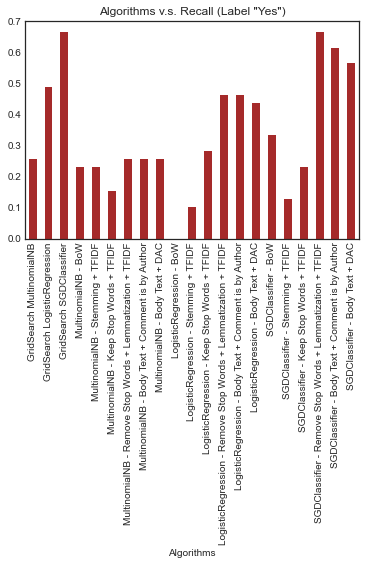

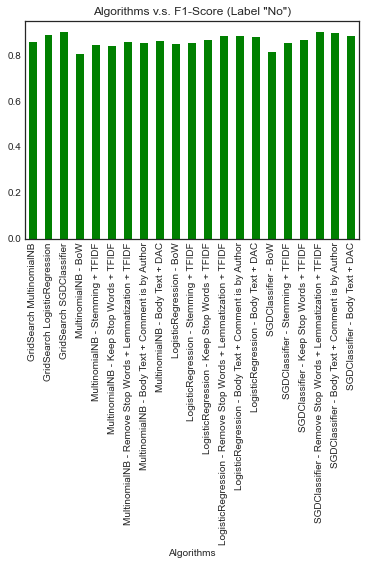

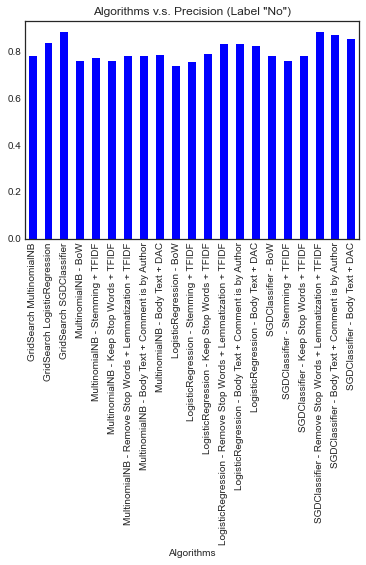

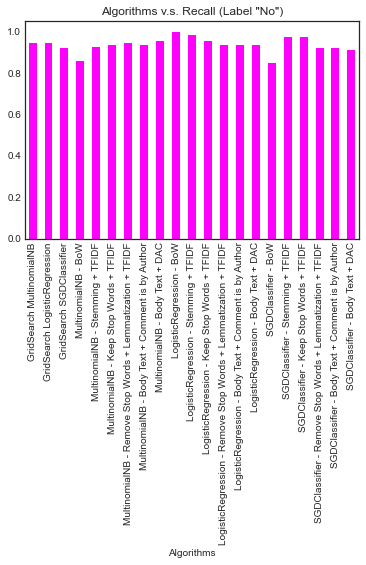

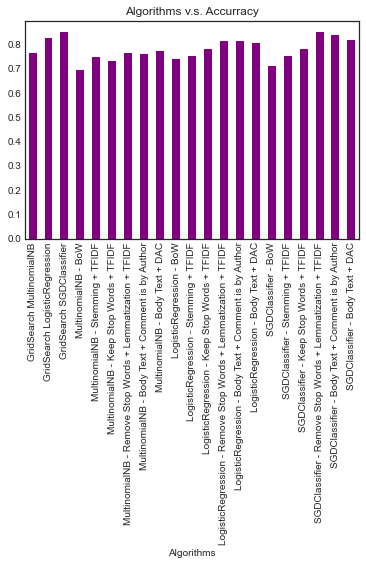

In [40]:
from matplotlib import pyplot

with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_fb_score', rot=90, title='Algorithms v.s. F-Beta-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)